In [112]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [113]:
# %pip install -r ../requirements.txt

In [114]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [115]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [116]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [117]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2017',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [118]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures(include_nb_hospit=False),
    # ft.AirQualityFeatures,
    # ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    # ft.GoogleTrendFeatures,
    # ft.MeteorologicalFeatures,
    # ft.SociologicalFeatures,
    # ft.PopulationFeatures,
    # ft.SportsCompetitionFeatures,
    # ft.TrafficFeatures
    ]

In [119]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [120]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [121]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [122]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14599bf10>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x145a01570>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x145a03370>)],
                  verbose=True)

In [123]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [124]:
features_config_get = {}

In [125]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2017',
    'to_date': '31-12-2023',
    'locations': ['CHU Dijon'], #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard'],
    'axis': 'columns',
    'shift': range(1, 7, 1),
    'rolling_window': [14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': 0, #-3,
    'targets_rolling_window': 0, #3,
    'targets_history_shifts': range(7, 14, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr':0.65,
    'data_dir': root_dir / 'data',
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    'target_bins': [0, 0.7, 1.0],
    'replace_target': True,
    }

In [126]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-14 17:10:44,474: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-14 17:10:44,483: INFO: Initialisation des features
root 2024-11-14 17:10:44,485: INFO: Fetching data for hospitalfeatures at CHU Dijon
root 2024-11-14 17:10:44,853: INFO: Getting the dataset from 01-01-2017 to 31-12-2023 for [<src.location.location.Location object at 0x14586d7e0>]
hospitalfeatures 2024-11-14 17:10:45,020: INFO: Getting data for hospitalfeatures from 2017-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
hospitalfeatures 2024-11-14 17:10:45,027: INFO: Augmentation des features...
root 2024-11-14 17:10:45,040: WARNING: Not shifting the target is not allowed as some features might not be available for today's date,                                            
as well as applying a positive shift as it would results in predicting the past                                            
Will use a default shift of -1 if targets_shift == 0 or of -targets_shift if targets_shift <

Dropped columns with zero variance: []
Dropped 0 constant columns from both sets: []
X shape: (1635, 1), y shape: (1635, 1)
            target_nb_emmergencies_CHU Dijon%%J+1
date                                             
2017-01-01                                    0.0
2017-01-02                                    0.0
2017-01-03                                    0.0
2017-01-04                                    0.0
2017-01-05                                    0.0
...                                           ...
2021-06-19                                    0.0
2021-06-20                                    1.0
2021-06-21                                    0.0
2021-06-22                                    0.0
2021-06-23                                    0.0

[1635 rows x 1 columns]
[ColumnTransformer] .... (1 of 2) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (2 of 2) Processing pipeline-4, total=   0.1s
            pipeline-3__cyclicalfeatures__date##month_sin  

In [127]:
df = arsTabularDataset.data['nb_emmergencies_CHU Dijon']

df

date
2017-01-01    141
2017-01-02    132
2017-01-03    123
2017-01-04    154
2017-01-05    136
             ... 
2023-12-26    177
2023-12-27    165
2023-12-28    192
2023-12-29    157
2023-12-30    212
Name: nb_emmergencies_CHU Dijon, Length: 2555, dtype: int64

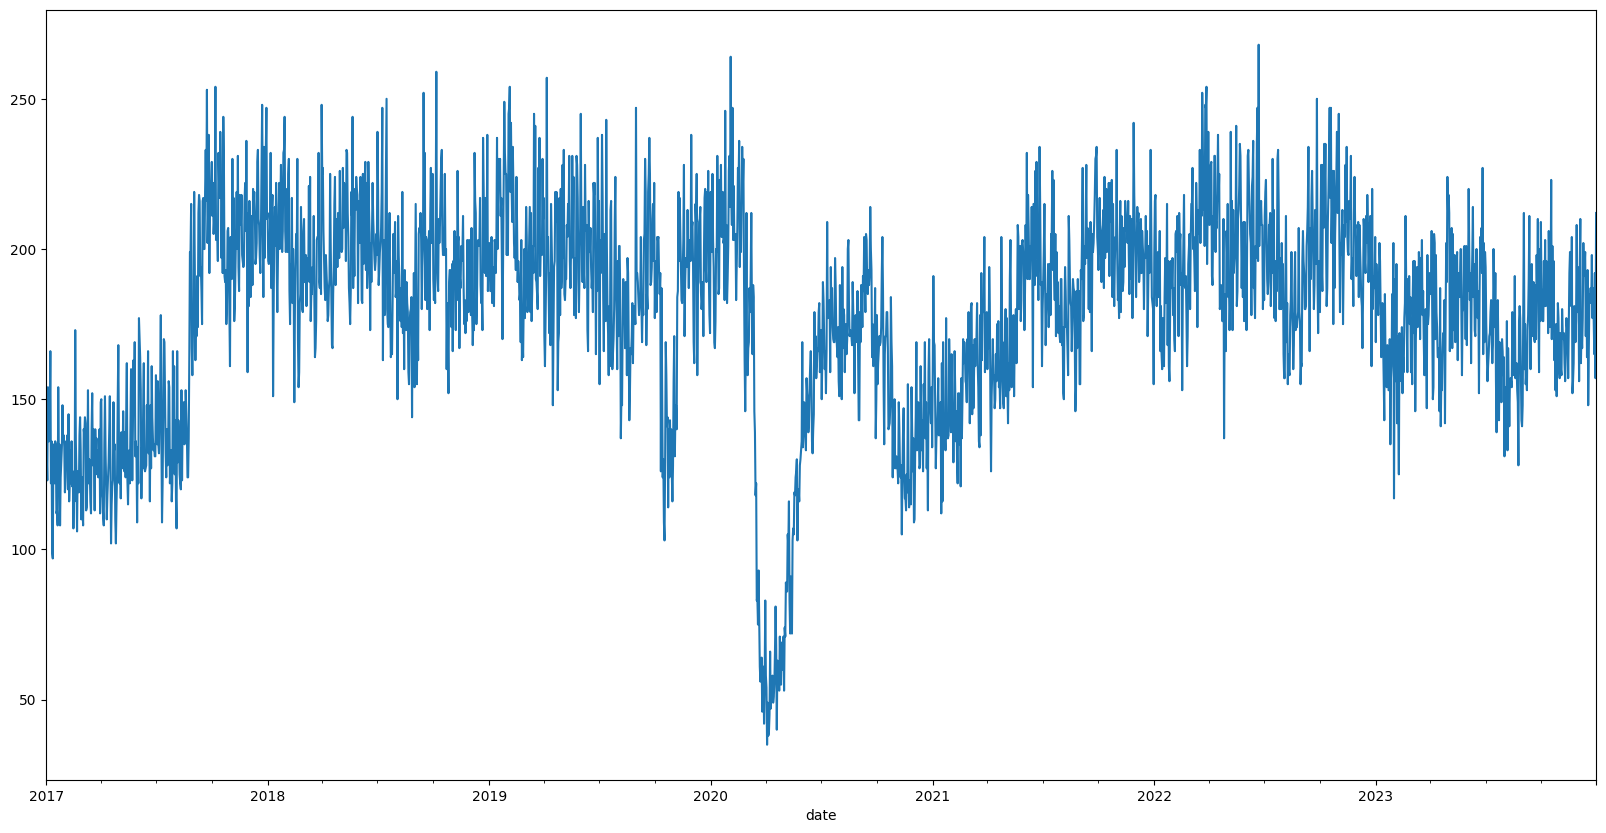

In [128]:
# plot df
import matplotlib.pyplot as plt

df.plot(subplots=True, figsize=(20, 10))
plt.show()

In [129]:
df

date
2017-01-01    141
2017-01-02    132
2017-01-03    123
2017-01-04    154
2017-01-05    136
             ... 
2023-12-26    177
2023-12-27    165
2023-12-28    192
2023-12-29    157
2023-12-30    212
Name: nb_emmergencies_CHU Dijon, Length: 2555, dtype: int64

In [130]:
d_max = '08-24-2017'
mean_high = df.loc['01-01-2018':'31-12-2019'].mean()
mean_low = df.loc['01-01-2017':d_max].mean()
df_normalized = df.copy()

df_normalized.loc['01-01-2017':d_max] = df.loc['01-01-2017':d_max] + (mean_high - mean_low)

 197.62170885 205.62170885 227.62170885 183.62170885 197.62170885
 160.62170885 158.62170885 194.62170885 196.62170885 183.62170885
 197.62170885 196.62170885 173.62170885 174.62170885 169.62170885
 215.62170885 191.62170885 196.62170885 169.62170885 185.62170885
 190.62170885 195.62170885 209.62170885 197.62170885 199.62170885
 195.62170885 180.62170885 185.62170885 197.62170885 193.62170885
 199.62170885 181.62170885 206.62170885 177.62170885 184.62170885
 194.62170885 183.62170885 197.62170885 182.62170885 187.62170885
 168.62170885 180.62170885 177.62170885 234.62170885 197.62170885
 185.62170885 167.62170885 187.62170885 184.62170885 180.62170885
 199.62170885 205.62170885 194.62170885 171.62170885 185.62170885
 174.62170885 169.62170885 201.62170885 199.62170885 205.62170885
 203.62170885 174.62170885 175.62170885 186.62170885 214.62170885
 183.62170885 191.62170885 187.62170885 177.62170885 173.62170885
 201.62170885 213.62170885 189.62170885 201.62170885 191.62170885
 174.62170

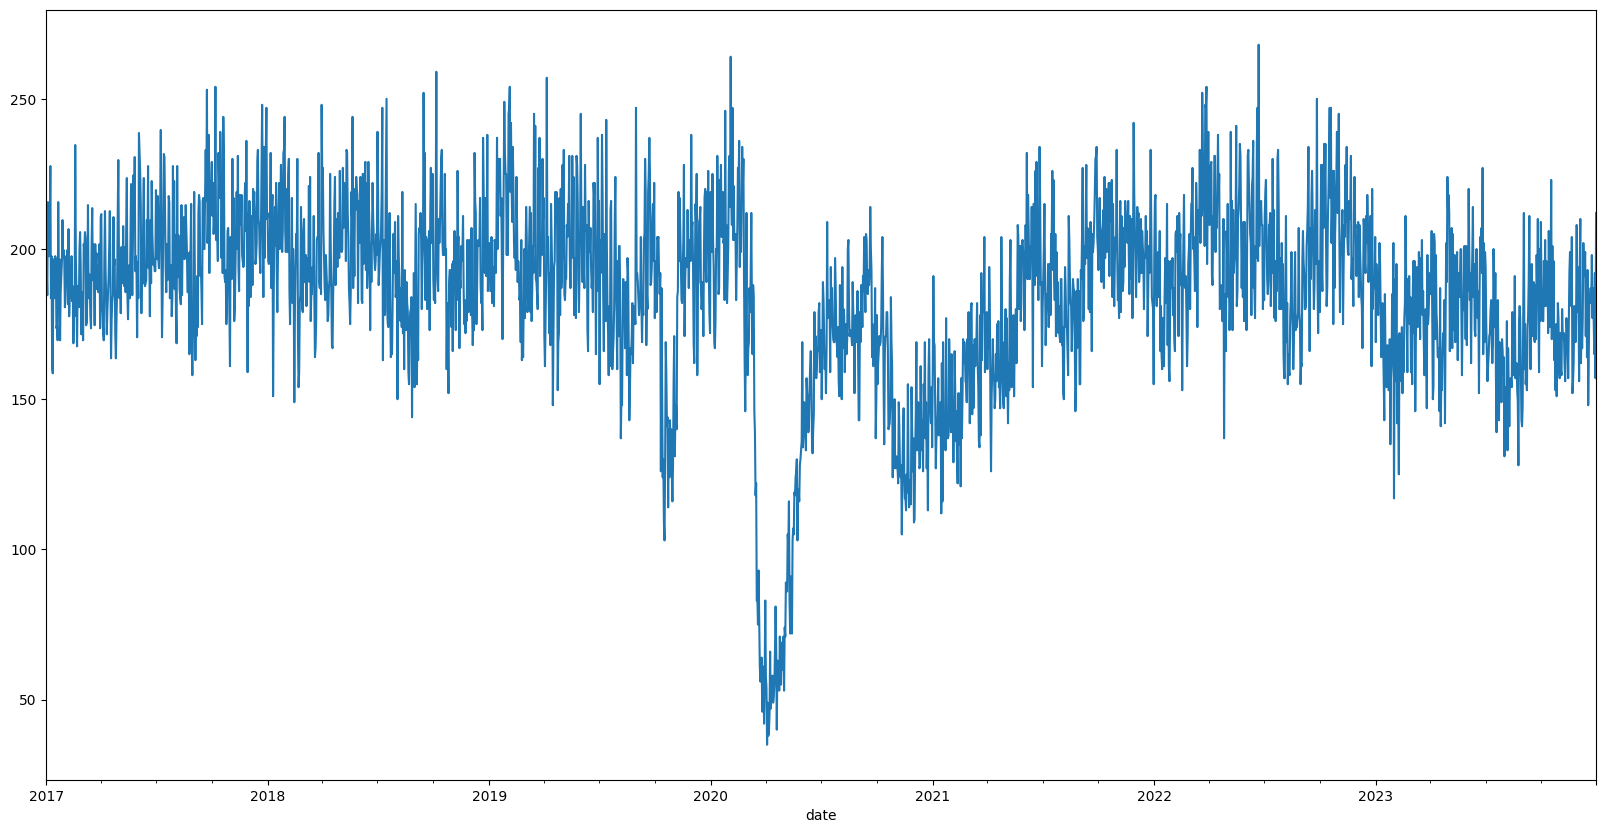

In [131]:
df_normalized.plot(subplots=True, figsize=(20, 10))
plt.show()

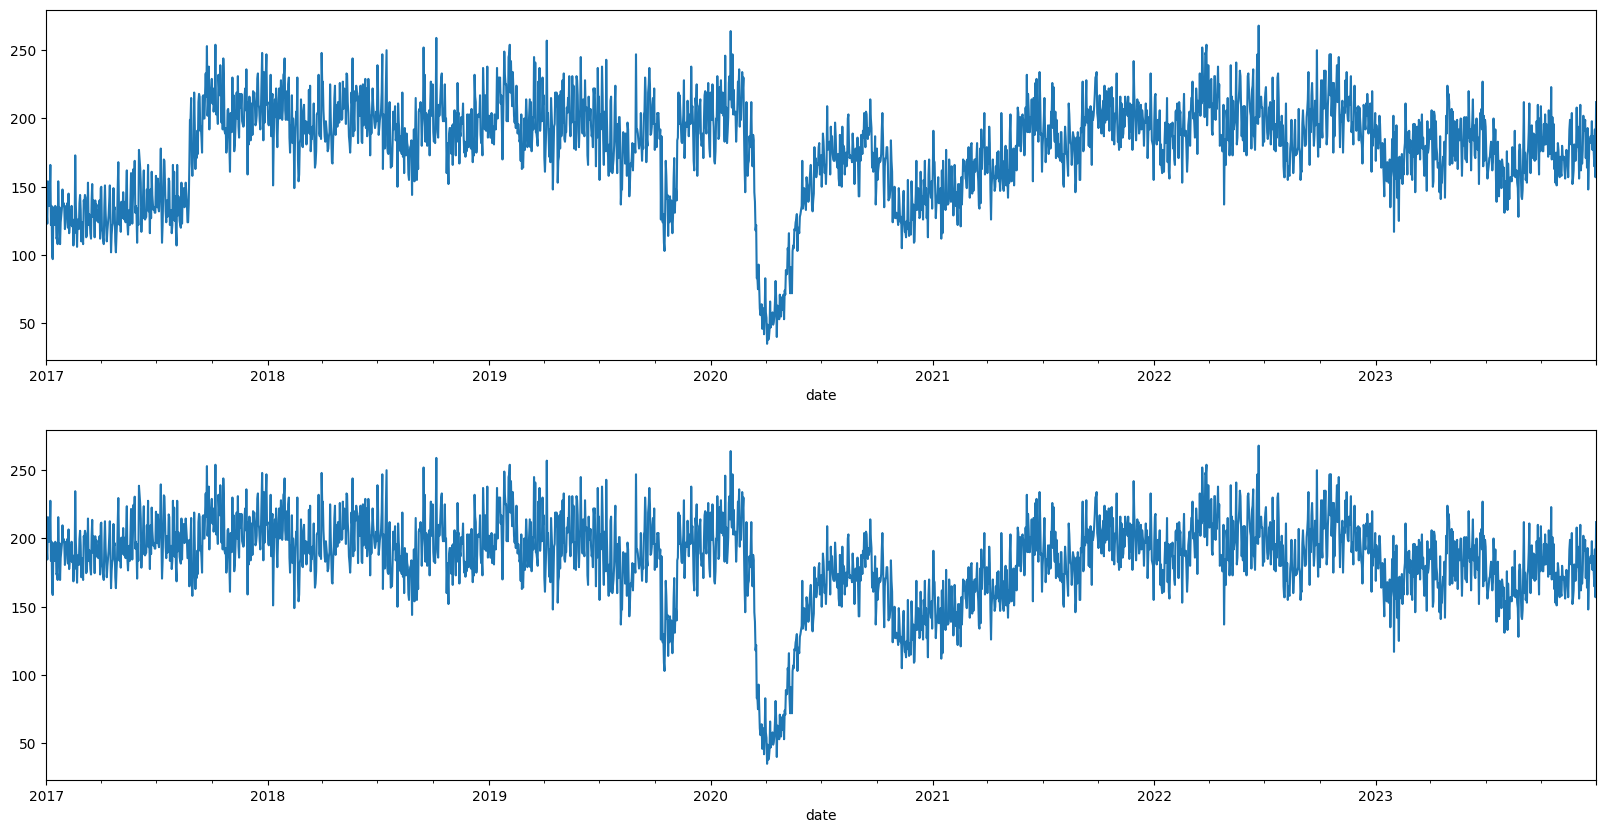

In [132]:
# subplot for both df and df_normalized
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
df.plot(subplots=True, ax=axs[0])
df_normalized.plot(subplots=True, ax=axs[1])
plt.show()

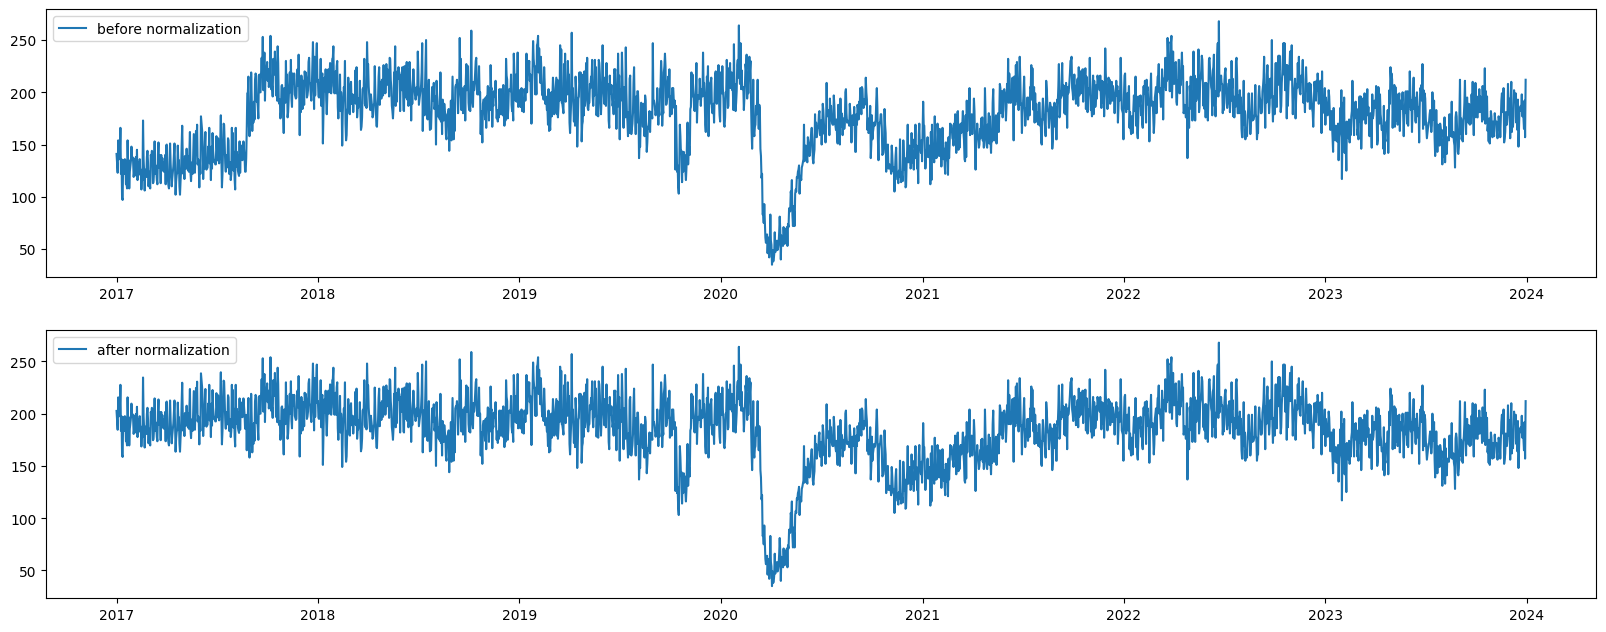

In [135]:
plt.figure(figsize=(20, 16))
plt.subplot(411)
plt.plot(df, label='before normalization')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(df_normalized, label='after normalization')
plt.legend(loc='upper left')

plt.show()